# US EPA Air Quality System API Example
This example illustrates how to request data from the US Environmental Protection Agency (EPA) Air Quality Service (AQS) API. This is a historical API and does not provide real-time air quality data. The [documentation](https://aqs.epa.gov/aqsweb/documents/data_api.html) for the API provides definitions of the different call parameter and examples of the various calls that can be made to the API.

This notebook works systematically through example calls, requesting an API key, using 'list' to get various IDs and parameter values, and using 'daily summary' to get summary data that meets specific condistions. The notebook contains example function definitions that could be reused in other code. In general, the notebook explains each step along the way, referring back to possible output. Some of the explanations are tailored to the specific example requests of the API. Changing values to explore the results of the API is probably useful, but that will result in some explanations being out of sync with the outputs.

The US EPA was created in the early 1970's. The EPA reports that they only started broad based monitoring with standardized quality assurance procedures in the 1980's. Many counties will have data starting somewhere between 1983 and 1988. However, some counties still do not have any air quality monitoring stations. The API helps resolve this by providing calls to search for monitoring stations and data using either station ids, or a county designation or a geographic bounding box. This example code provides examples of the county based and bounding box based API calls. Some [additional information on the Air Quality System can be found in the EPA FAQ](https://www.epa.gov/outdoor-air-quality-data/frequent-questions-about-airdata) on the system.

The end goal of this example is to get to some values that we might use for the Air Quality Index or AQI. You might see this reported on the news, most often around smog, but more frequently with regard to smoke. The AQI index is meant to tell us something about how healthy or clean the air is on any day. The AQI is actually a somewhat complext measure. When I started this example I looked up [how to calculate the AQI](https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf) so that I would know roughly what goes into that value.


## License
This code example was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.2 - August 16, 2024

The following pieces of code were used from Dr. David W. McDonald's Python Notebook File `epa_air_quality_history_example.ipynb`: 
1. API Request Template
2. `request_signup`
3. `request_list_info`
4. `request_daily_summary`


The rest of the code lies under the standard MIT license.


#### External Libraries
Install these dependencies for `pandas`, `matplotlib` and `numpy` that we will be using for dataframe manipulation by uncommenting the below cell

In [1]:
# ! pip install pandas
# ! pip install numpy
# !pip install matplotlib

In [42]:
#
# External Libraries
#

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Standard Python Libraries Required

In [3]:
# 
#    These are standard python modules
#
#import json, time, urllib.parse
import json, time
#
#    The 'requests' module is a distribution module for making web requests. If you do not have it already, you'll need to install it
import requests

This below code defines constants and templates for interacting with the Air Quality System (AQS) API managed by the EPA. The `API_REQUEST_URL` serves as the base URL for all API requests. Various endpoint actions are provided, including `signup` to request an API key, `list` actions to retrieve data classes, parameters, and sites, and `monitor` actions to gather monitoring station data based on specific criteria, such as county or geographical bounding box. It also includes `summary` actions to access daily data summaries in county or bounding-box areas. 

In this project, we will be proceeding with using the daily data summaries approach.

An API request template (`AQS_REQUEST_TEMPLATE`) is prepared with placeholder fields for commonly used parameters like email, API key, geographic and date ranges, and parameters for data requests. Additionally, a throttle setting (`API_THROTTLE_WAIT`) is established to maintain a respectful rate limit, assuming an estimated latency for each request. This setup provides a structured approach for handling varied air quality data requests efficiently.

In [4]:
#########
#
#    CONSTANTS
#

#
#    This is the root of all AQS API URLs
#
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#
#    These are some of the 'actions' we can ask the API to take or requests that we can make of the API
#
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
# 
AQS_REQUEST_TEMPLATE = {
    "email":      "",     
    "key":        "",      
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}



## Example 1. Making a sign-up request

Before you can use the API you need to request a key. You will use an email address to make the request. The EPA then sends a confirmation email link and a 'key' that you use for all other requests.

You only need to sign-up once, unless you want to invalidate your current key (by getting a new key) or you lose your key.


In [5]:
#
#    This implements the sign-up request. The parameters are standardized so that this function definition matches
#    all of the others. However, the easiest way to call this is to simply call this function with your preferred
#    email address.
#
def request_signup(email_address = None,
                   endpoint_url = API_REQUEST_URL, 
                   endpoint_action = API_ACTION_SIGNUP, 
                   request_template = AQS_REQUEST_TEMPLATE,
                   headers = None):
    
    # Make sure we have a string - if you don't have access to this email addres, things might go badly for you
    if email_address:
        request_template['email'] = email_address        
    
    if not request_template['email']: 
        raise Exception("Must supply an email address to call 'request_signup()'")

    if '@' not in request_template['email']: 
        raise Exception(f"Must supply an email address to call 'request_signup()'. The string '{request_template['email']}' does not look like an email address.")

    # Compose the signup url - create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response



A SIGNUP request is only to be done once, to request a key. A key is sent to that email address and needs to be confirmed with a click through.

This below code should probably be commented out after you've made your key request to make sure you don't accidentally make a new sign-up request

In [6]:

#    A SIGNUP request is only to be done once, to request a key. A key is sent to that email address and needs to be confirmed with a click through
#    This code should probably be commented out after you've made your key request to make sure you don't accidentally make a new sign-up request

# print("Requesting SIGNUP ...")
# USERNAME = "needula@uw.edu"
# response = request_signup(USERNAME)
# print(json.dumps(response,indent=4))


A response to the signup request might look something like this.


    Requesting SIGNUP ...
    {
        "Header": [
            {
                "status": "Success",
                "request_time": "2023-08-07T17:03:27-04:00",
                "url": "https://aqs.epa.gov/data/api/signup?email=dwmc@uw.edu"
            }
        ],
        "Data": [
            "You should receive a registration confirmation email with a link for confirming your email shortly."
        ]
    }



**Note:** The code below relies on a user module called apikeys that is a key manager. You don't need that to make this code work. You can use the email you used for your sign-up request and the key that you got in email. Assign your email address to "USERNAME" and your key to "APIKEY" as constants and the remaining cells in the notbook should work.

I've used my API key and removed it from the code below to avoid exposing sensitive this information. The `APIKEY` filed below can be replaced by your own key after doing the sign up request.

In [11]:
#
# Credentials to use API
#

USERNAME = "needula@uw.edu"
APIKEY = "bluemallard93"

## Example 2. Making a list request
Once you have a key, the next thing is to get information about the different types of air quality monitoring (sensors) and the different places where we might find air quality stations. The monitoring system is complex and changes all the time. The EPA implementation allows an API user to find changes to monitoring sites and sensors by making requests - maybe monthly, or daily. This API approach is probably better than having the EPA publish documentation that may be out of date as soon as it hits a web page. The one problem here is that some of the responses rely on jargon or terms-of-art. That is, one needs to know a bit about the way atmospheric sciece works to understand some of the terms.

This code defines `request_list_info`, a function that retrieves various metadata lists from the AQS API, such as groups or parameter class descriptors. This information is essential for identifying specific air quality measurement codes, allowing users to later make targeted requests using proprietary 5-digit codes. The function takes parameters for `email_address` and `key`, which are necessary for accessing the API, and assigns them to a `request_template` if provided. If either is missing, it raises an exception. The function then constructs a request URL by combining the API’s base URL and action for list requests, formatted with the template values. Before sending the request, a throttle delay is applied to avoid surpassing API rate limits. The function attempts to make a `GET` request, parses the response as JSON, and handles any errors by printing the exception and returning `None`. 

In [12]:
#
#    This implements the list request. There are several versions of the list request that only require email and key.
#    This code sets the default action/requests to list the groups or parameter class descriptors. Having those descriptors 
#    allows one to request the individual (proprietary) 5 digit codes for individual air quality measures by using the
#    param request. Some code in later cells will illustrate those requests.
#
def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL, 
                      endpoint_action = API_ACTION_LIST_CLASSES, 
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):
    
    #  Make sure we have email and key - at least
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    
    # For the basic request we need an email address and a key
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_list_info()'")

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

The default should get us a list of the various groups or classes of sensors. These classes are user defined names for clusters of sensors that might be part of a package or default air quality sensing station. We need a class name to start getting down to the a sensor ID. Each sensor type has an ID number. We'll eventually need those ID numbers to be able to request values that come from that specific sensor.

In [13]:
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY

response = request_list_info(request_template=request_data)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "AIRNOW MAPS",
        "value_represented": "The parameters represented on AirNow maps (88101, 88502, and 44201)"
    },
    {
        "code": "ALL",
        "value_represented": "Select all Parameters Available"
    },
    {
        "code": "AQI POLLUTANTS",
        "value_represented": "Pollutants that have an AQI Defined"
    },
    {
        "code": "CORE_HAPS",
        "value_represented": "Urban Air Toxic Pollutants"
    },
    {
        "code": "CRITERIA",
        "value_represented": "Criteria Pollutants"
    },
    {
        "code": "CSN DART",
        "value_represented": "List of CSN speciation parameters to populate the STI DART tool"
    },
    {
        "code": "FORECAST",
        "value_represented": "Parameters routinely extracted by AirNow (STI)"
    },
    {
        "code": "HAPS",
        "value_represented": "Hazardous Air Pollutants"
    },
    {
        "code": "IMPROVE CARBON",
        "value_represented": "IMPROVE Carbon Parameters"
    }

We're interested in getting to something that might be the Air Quality Index (AQI). You see this reported on the news - often around smog values, but also when there is smoke in the sky. The AQI is a complex measure of different gasses and of the particles in the air (dust, dirt, ash ...).

From the list produced by our 'list/Classes' request above, it looks like there is a class of sensors called "AQI POLLUTANTS". Let's try to get a list of those specific sensors and see what we can get from those.


Once we have a list of the classes or groups of possible sensors, we can find the sensor IDs that make up that class (group). The one that looks to be associated with the Air Quality Index is "AQI POLLUTANTS". We'll use that to make another list request.

In [14]:
AQI_PARAM_CLASS = "AQI POLLUTANTS"

#
#   Structure a request to get the sensor IDs associated with the AQI
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['pclass'] = AQI_PARAM_CLASS  # here we specify that we want this 'pclass' or parameter classs

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_PARAMS)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "42101",
        "value_represented": "Carbon monoxide"
    },
    {
        "code": "42401",
        "value_represented": "Sulfur dioxide"
    },
    {
        "code": "42602",
        "value_represented": "Nitrogen dioxide (NO2)"
    },
    {
        "code": "44201",
        "value_represented": "Ozone"
    },
    {
        "code": "81102",
        "value_represented": "PM10 Total 0-10um STP"
    },
    {
        "code": "88101",
        "value_represented": "PM2.5 - Local Conditions"
    },
    {
        "code": "88502",
        "value_represented": "Acceptable PM2.5 AQI & Speciation Mass"
    }
]


We should now have (above) a response containing a set of sensor ID numbers. The list should include the sensor numbers as well as a description or name for each sensor. 

The EPA AQS API has limits on some call parameters. Specifically, when we request data for sensors we can only specify a maximum of 5 different sensor values to return. This means we cannot get all of the Air Quality Index parameters in one request for data. We have to break it up.

What we did below was to break the request into two logical groups, the AQI sensors that sample gasses and the AQI sensors that sample particles in the air.

In [15]:
#
#   Given the set of sensor codes, now we can create a parameter list or 'param' value as defined by the AQS API spec.
#   It turns out that we want all of these measures for AQI, but we need to have two different param constants to get
#   all seven of the code types. We can only have a max of 5 sensors/values request per param.
#
#   Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
#
#   Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"
#   
#

Air quality monitoring stations are located all over the US at different locations. We will need some sample locations to experiment with different locations to see what kinds of values come back from different sensor requests.

This list includes the [FIPS](https://www.census.gov/library/reference/code-lists/ansi.html) number for the state and county as a 5 digit string. This format, the 5 digit string, is a 'old' format that is still widely used. There are new codes that may eventually be adopted for the US government information systems. But FIPS is currently what the AQS uses, so that's what is in the list as the constant.

We are interested in exploring the AQI data for the city Centennial, CO.

The below fields were filled by doing a simple Google Search to find the county, and the fips. The latitude and longitude were taken from the original source - the GeoHack website.

In [16]:
CITY_LOCATIONS = {
    'centennial' :     {'city'   : 'Centennial',
                    'county' : 'Arapahoe',
                    'state'  : 'Colorado',
                    'fips'   : '08005',
                    'latlon' : [39.59, -104.87]  
                         }
}

For this city, we are using the EPA to list their monitoring stations by county. 

This list request should give us a list of all the monitoring stations in the county specified by the given city selected from the CITY_LOCATIONS dictionary

For my city, Centennial, the API request returned 14 monitoring stations. I deemed that these 14 stations would collect enough data for the AQI. Hence, I picked this approach over the bounding box approach.

In [17]:
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['centennial']['fips'][:2]   # the first two digits (characters) of FIPS is the state code
request_data['county'] = CITY_LOCATIONS['centennial']['fips'][2:]  # the last three digits (characters) of FIPS is the county code

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_SITES)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "0001",
        "value_represented": "CHERRY CREEK DAM"
    },
    {
        "code": "0002",
        "value_represented": "HIGHLAND RESERVOIR"
    },
    {
        "code": "0003",
        "value_represented": null
    },
    {
        "code": "0004",
        "value_represented": null
    },
    {
        "code": "0005",
        "value_represented": "Arapahoe Community College"
    },
    {
        "code": "0006",
        "value_represented": "Aurora East"
    },
    {
        "code": "0007",
        "value_represented": "Centennial Airport"
    },
    {
        "code": "0600",
        "value_represented": "SPECIAL STUDY CO SITE 1986/1987 LOCATED AT MILLER SCHOOL"
    },
    {
        "code": "0824",
        "value_represented": "SPECIAL STUDY CO SITE 1982 LOCATED AT MILLER SCHOOL (CITY OF ENGLWD)"
    },
    {
        "code": "0825",
        "value_represented": "GREENWOOD VILLAGE"
    },
    {
        "code": "1001",
        "value_represented": null
    },
   


The above response gives us a list of monitoring stations. Each monitoring station has a unique "code" which is a string number, and, sometimes, a description. The description seems to be something about where the monitoring station is located.


The above code response a list of 14 monitoring stations for Centennial, CO. I decided that this was sufficient data to proceed with my analysis.

## Example 3. Making a daily summary request

The function below is designed to encapsulate requests to the EPA AQS API. When calling the function one should create/copy a parameter template, then initialize that template with values that won't change with each call. Then on each call simply pass in the parameters that need to change, like date ranges.

This function below is designed to request a daily summary of air quality data from the EPA for specified sensors over a defined date range. Users can provide parameters either through a dictionary or directly as function arguments. The function constructs an API request based on these parameters, ensuring all required fields are populated, and handles potential errors during the request process. It returns the JSON response containing the requested data or None if an error occurs.

This function streamlines the process of querying the AQS API for daily air quality summaries, making it easier to access historical data from 1964 to 2024. Furthermore, another filter is applied to only retrieve the data during "Wildfire Season" which is from May to October every year. 

Like mentioned previously, the API does have some rate limitations. For example, when I tried to get data for 60 years at once (instead of via a for loop), I ran into the error below. Hence, I decided to (1) limit my dates to only the wildfire months (2) run a loop over 60 years to overcome this error. 

```
Response for the gaseous pollutants ...
Data for 60 years ...
{
    "Header": [
        {
            "status": "Failed",
            "request_time": "2024-10-26T23:09:03.035-04:00",
            "url": "https://aqs.epa.gov/data/api/dailyData/byCounty?email=needula@uw.edu&key=bluemallard93&param=42101,42401,42602,44201&bdate=19640101&edate=20241026&state=08&county=005",
            "error": [
                "bdate: 19640101, edate: 20241026, only 1 year of data is permitted."
            ]
        }
    ]
}
```

In [18]:
# This function implements a daily summary request for air quality data from the EPA.
# It retrieves a daily summary value for each specified sensor from a start date to an end date.
# The function can accept parameters either through a dictionary or as individual arguments,
# with function parameters taking precedence over the request template parameters.

START_MMDD = "0501" 
END_MMDD = "1031"
YEAR_START = 1964
YEAR_END = 2024

def request_daily_summary(email_address=None, key=None, param=None,
                          begin_date=None, end_date=None, fips=None,
                          endpoint_url=API_REQUEST_URL, 
                          endpoint_action=API_ACTION_DAILY_SUMMARY_COUNTY, 
                          request_template=AQS_REQUEST_TEMPLATE,
                          headers=None):
    """
    Requests a daily summary of air quality data from the EPA.

    Parameters:
        email_address (str): The email address for API access.
        key (str): The API key for authentication.
        param (str): The specific parameter to retrieve (e.g., pollutant type).
        begin_date (str): The start date for the data request (format: YYYY-MM-DD).
        end_date (str): The end date for the data request (format: YYYY-MM-DD).
        fips (str): The FIPS code for the specific region (state and county).
        endpoint_url (str): The base URL for the API request.
        endpoint_action (str): The specific action to perform on the API.
        request_template (dict): A template for the API request parameters.
        headers (dict): Any additional headers to include in the request.

    Returns:
        dict: The JSON response containing the daily summary data.
    
    Raises:
        Exception: If required parameters are not provided.
    """
    
    # Update request_template with provided parameters, prioritizing function arguments over template defaults
    request_template.update({
        'email': email_address if email_address else request_template.get('email'),
        'key': key if key else request_template.get('key'),
        'param': param if param else request_template.get('param'),
        'begin_date': begin_date if begin_date else request_template.get('begin_date'),
        'end_date': end_date if end_date else request_template.get('end_date'),
    })
    
    # Handle FIPS code if provided
    if fips and len(fips) == 5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]

    # Ensure all required fields are populated
    for field in ['email', 'key', 'param', 'begin_date', 'end_date']:
        if not request_template[field]:
            raise Exception(f"Must supply {field} to call 'request_daily_summary()'")

    # Compose the request URL
    request_url = f"{endpoint_url}{endpoint_action.format(**request_template)}"
    
    # Make the request while handling potential errors
    try:
        # Throttle the request if necessary to avoid exceeding API limits
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        response.raise_for_status()  # Raise an error for bad responses
        json_response = response.json()  # Parse JSON response
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        json_response = None
        
    return json_response

Hence, the function `extract_AQI_data` was created. The `extract_AQI_data` function is designed to process the JSON response received from an air quality index (AQI) API request. It checks the status of the response to determine whether the request was successful. If the status indicates "Success," the function extracts and returns the relevant AQI data, which consists of a list of dictionaries, each representing daily measurements for various sensors. If the status begins with "No data," the function does nothing and simply exits, implying that the request may need further inspection. In the event of any other status, it prints an error message along with the full JSON response for debugging purposes. If the function encounters any issues, it returns `None` to indicate that no valid data could be extracted. This function is integral to handling the response from the AQI API, allowing users to retrieve meaningful air quality data while managing potential errors effectively. 

Following the function definition, the code initializes a dictionary, `request_data`, using a template that includes the user's email and API key, as well as state and county information specific to Centennial, CO.

In [19]:
#
## Defining Date Constants
#

START_MMDD = "0501" 
END_MMDD = "1031"
YEAR_START = 1964
YEAR_END = 2024

def extract_AQI_data(aqi_JSON):
    """
    Extracts AQI Data from JSON response if the request is successful.
    
    Parameters: 
        aqi_JSON (dict): The raw JSON response of the request.
    Return:
        list: A list of dictionaries denoting each sensor's measurement for a day.
    """
    # Check if the request status is "Success"
    if aqi_JSON["Header"][0]['status'] == "Success":
        return aqi_JSON['Data']
    
    # Check if there's no data available
    if aqi_JSON["Header"][0]['status'].startswith("No data "):
        return []  # Return an empty list if there's no data
    
    # Handle any unexpected status
    print("Unexpected error occured!")
    print(json.dumps(aqi_JSON, indent=4))
    return None

# Prepare the request data by copying the template
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['centennial']['fips'][:2] 
request_data['county'] = CITY_LOCATIONS['centennial']['fips'][2:] 

The code snippets below retrieves air quality index (AQI) data for gaseous pollutants across a the date range. over multiple years. We iterate for each year during fire season for each year from May 1st to October 31st. For each year, we obtain a daily summary of gaseous AQI data. If data is missing, a message is printed for that year. 

It took about 23 minutes to get the data for gaseous pollutants.

In [20]:
%%time
gaseous_responses = []

# Iterate through all the years
for year in range(YEAR_START, YEAR_END + 1):
    # Define start and end times for the fire season
    begin_date = f"{year}{START_MMDD}"  # Formatted date string for start
    end_date = f"{year}{END_MMDD}"  # Formatted date string for end
    
    # Request daily summary data for gaseous pollutants
    request_data['param'] = AQI_PARAMS_GASEOUS
    gaseous_aqi = request_daily_summary(
        request_template=request_data, begin_date=begin_date, end_date=end_date)
    
    # Extract data from the response
    gas_list = extract_AQI_data(gaseous_aqi)

    # Append responses to the larger set if available
    if gas_list:  # If there is data, add it to the responses
        gaseous_responses.extend(gas_list)
    else:  # If no data is found for the year, notify
        print(f"No gaseous data available for {year}.")


No gaseous data available for 1964.
No gaseous data available for 1965.
No gaseous data available for 1966.
No gaseous data available for 1967.
No gaseous data available for 1968.
No gaseous data available for 1969.
No gaseous data available for 1970.
No gaseous data available for 1971.
No gaseous data available for 1972.
No gaseous data available for 1973.
No gaseous data available for 1974.
No gaseous data available for 1975.
No gaseous data available for 1976.
No gaseous data available for 1977.
No gaseous data available for 2008.
CPU times: total: 12.7 s
Wall time: 23min 10s


Dumping the JSON object to a file to avoid re-running this piece of code in the future.

In [21]:
with open("gaseous_aqi_temp_data", 'w') as json_file:
    json.dump(gaseous_responses, json_file, indent=4) 

It took about 22 minutes to get the data for gaseous pollutants

In [22]:
%%time
particulate_responses = []

for year in range(YEAR_START, YEAR_END + 1):
    # Define start and end times for the fire season
    begin_date = str(year) + START_MMDD
    end_date = str(year) + END_MMDD
    
        
    # Request daily summary data for particulate pollutants
    request_data['param'] = AQI_PARAMS_PARTICULATES
    particulate_aqi = request_daily_summary(
        request_template=request_data, begin_date=begin_date, end_date=end_date)
    part_list = extract_AQI_data(particulate_aqi)
    
        
    if part_list:
        particulate_responses.extend(part_list)
    else:
        print(f"No particulate data available for {year}.")

No particulate data available for 1964.
No particulate data available for 1965.
No particulate data available for 1966.
No particulate data available for 1967.
No particulate data available for 1968.
No particulate data available for 1969.
No particulate data available for 1970.
No particulate data available for 1971.
No particulate data available for 1972.
No particulate data available for 1973.
No particulate data available for 1974.
No particulate data available for 1975.
No particulate data available for 1976.
No particulate data available for 1977.
No particulate data available for 1978.
No particulate data available for 1979.
No particulate data available for 1980.
No particulate data available for 1981.
No particulate data available for 1982.
No particulate data available for 1983.
No particulate data available for 1984.
No particulate data available for 1985.
No particulate data available for 1995.
No particulate data available for 1996.
No particulate data available for 1997.


Dumping the JSON object to a file to avoid re-running this piece of code in the future.

In [23]:
with open("particulate_aqi_temp_full", 'w') as json_file:
    json.dump(particulate_responses, json_file, indent=4)  # indent for pretty printing

## Quick Overview of the Data

Firstly, let's convert both these JSON object to pandas dataframes so that we can analyze them easily.

In [24]:
df_particulate = pd.DataFrame(particulate_responses)
df_gaseous = pd.DataFrame(gaseous_responses)

In [25]:
df_particulate.columns

Index(['state_code', 'county_code', 'site_number', 'parameter_code', 'poc',
       'latitude', 'longitude', 'datum', 'parameter', 'sample_duration_code',
       'sample_duration', 'pollutant_standard', 'date_local',
       'units_of_measure', 'event_type', 'observation_count',
       'observation_percent', 'validity_indicator', 'arithmetic_mean',
       'first_max_value', 'first_max_hour', 'aqi', 'method_code', 'method',
       'local_site_name', 'site_address', 'state', 'county', 'city',
       'cbsa_code', 'cbsa', 'date_of_last_change'],
      dtype='object')

In [26]:
df_gaseous.columns

Index(['state_code', 'county_code', 'site_number', 'parameter_code', 'poc',
       'latitude', 'longitude', 'datum', 'parameter', 'sample_duration_code',
       'sample_duration', 'pollutant_standard', 'date_local',
       'units_of_measure', 'event_type', 'observation_count',
       'observation_percent', 'validity_indicator', 'arithmetic_mean',
       'first_max_value', 'first_max_hour', 'aqi', 'method_code', 'method',
       'local_site_name', 'site_address', 'state', 'county', 'city',
       'cbsa_code', 'cbsa', 'date_of_last_change'],
      dtype='object')

As expected, both the dataframes have the same set of columns. 

For our convenience, let's filter out the columns that are important for our analysis.

In [27]:
# Keep important columns
df_gaseous_select = df_gaseous[['state_code', 'county_code', 'site_number', 'parameter_code', 'latitude', 'longitude', 'parameter', 'sample_duration', 'date_local', 'units_of_measure', 'arithmetic_mean',
       'first_max_value', 'aqi']]
df_particulate_select = df_particulate[['state_code', 'county_code', 'site_number', 'parameter_code', 'latitude', 'longitude', 'parameter', 'sample_duration', 'date_local', 'units_of_measure', 'arithmetic_mean',
       'first_max_value', 'aqi']]

When I was manual checking the data, I observed that the dataset contained duplicate rows. For each monitoring station, if the AQI was recorded over multiple intervals (e.g., 1-hour and 8-hour intervals), both values were retained. I chose to remove these duplicates to streamline the data.

In [29]:
print(f"There are a total of {len(df_gaseous_select)} rows in the gaseous pollutants dataframe.")
df_gaseous_unique = df_gaseous_select.drop_duplicates()
print(f"After dropping the duplicate rows, there are {len(df_gaseous_unique)} rows in the gaseous pollutants dataframe.")

print(f"There are a total of {len(df_particulate_select)} rows in the particulate pollutants dataframe.")
df_particulate_unique = df_particulate_select.drop_duplicates()
print(f"After dropping the duplicate rows, there are {len(df_particulate_unique)} rows in the particulate pollutants dataframe.")

There are a total of 69406 rows in the gaseous pollutants dataframe.
After dropping the duplicate rows, there are 53602 rows in the gaseous pollutants dataframe.
There are a total of 13127 rows in the particulate pollutants dataframe.
After dropping the duplicate rows, there are 1954 rows in the particulate pollutants dataframe.


Now let's concatenate the two dataframes

In [30]:
df_concat = pd.concat([df_gaseous_unique, df_particulate_unique], axis=0)
len(df_concat)
df_concat

,state_code,county_code,site_number,parameter_code,latitude,longitude,parameter,sample_duration,date_local,units_of_measure,arithmetic_mean,first_max_value,aqi
0,08,005,0002,42101,39.567887,-104.957193,Carbon monoxide,1 HOUR,1978-09-16,Parts per million,0.000000,0.0,NaN
1,08,005,0002,42101,39.567887,-104.957193,Carbon monoxide,8-HR RUN AVG END HOUR,1978-09-16,Parts per million,0.000000,0.0,0.0
2,08,005,0002,42101,39.567887,-104.957193,Carbon monoxide,1 HOUR,1978-09-17,Parts per million,0.250000,1.0,NaN
3,08,005,0002,42101,39.567887,-104.957193,Carbon monoxide,8-HR RUN AVG END HOUR,1978-09-17,Parts per million,0.183333,0.4,5.0
4,08,005,0002,42101,39.567887,-104.957193,Carbon monoxide,1 HOUR,1978-09-18,Parts per million,0.625000,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12432,08,005,0005,88101,39.604399,-105.019526,PM2.5 - Local Conditions,1 HOUR,2024-08-27,Micrograms/cubic meter (LC),4.016667,6.8,NaN
12433,08,005,0005,88101,39.604399,-105.019526,PM2.5 - Local Conditions,1 HOUR,2024-08-28,Micrograms/cubic meter (LC),3.787500,6.0,NaN
12434,08,005,0005,88101,39.604399,-105.019526,PM2.5 - Local Conditions,1 HOUR,2024-08-29,Micrograms/cubic meter (LC),5.404167,10.0,NaN
12435,08,005,0005,88101,39.604399,-105.019526,PM2.5 - Local Conditions,1 HOUR,2024-08-30,Micrograms/cubic meter (LC),5.237500,8.0,NaN


Let's check for how many monitoring stations we still have retained the data from after filtering and dropping duplicates.

In [31]:
unique_combinations_of_stations = df_concat[['state_code', 'county_code', 'site_number']].drop_duplicates()
unique_combinations_of_stations

,state_code,county_code,site_number
0,08,005,0002
2522,08,005,1002
6313,08,005,0824
6347,08,005,0825
16447,08,005,0600
21522,08,005,0003
21634,08,005,0004
48834,08,005,0006
0,08,005,1001
241,08,005,0005


Looks like we have retained data from most of the monitoring sites, which is a good sign.

In [32]:
print(f"Our data has the following list of pollutants that affect the AQI index:")
df_concat['parameter'].unique()

Our data has the following list of pollutants that affect the AQI index:


array(['Carbon monoxide', 'Sulfur dioxide', 'Ozone',
       'Nitrogen dioxide (NO2)', 'PM10 Total 0-10um STP',
       'PM2.5 - Local Conditions'], dtype=object)

#### Feature Engineering

To assess whether the monitoring station provides an accurate AQI measurement for Centennial, we need to calculate its distance from the city. This will help determine if the station is close enough to reflect local air quality accurately.

To perform this calculation, I used the **Haversine distance** formula. The Haversine formula calculates the great-circle distance between two points on a sphere given their latitude and longitude. This is okay to use for small distances where Earth’s curvature is minimal. For this, I utilized the `pyproj` library in the data acquisition code, which provides a fast and efficient calculation, especially suited for shorter distances. Other distance calculation methods proved slower on my computer and this seemed like a reliable enough method for this context.

In [33]:

# Reference coordinates
city_latitude = 39.59
city_longitude = -104.87

# Haversine function to calculate distance in miles
def haversine(lat1, lon1, lat2, lon2):
    R = 3956  # Earth radius in miles
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Calculate distances and add to DataFrame
df_concat['distance'] = df_concat.apply(lambda row: haversine(city_latitude, city_longitude, row['latitude'], row['longitude']), axis=1)

# Normalize distances for weighting (inverse weighting)
max_distance = df_concat['distance'].max()
min_distance = df_concat['distance'].min()

# print range
print(max_distance)
print(min_distance)

# Display the DataFrame with distances and weights
df_concat


16.339305037391007
1.9966097390437276


,state_code,county_code,site_number,parameter_code,latitude,longitude,parameter,sample_duration,date_local,units_of_measure,arithmetic_mean,first_max_value,aqi,distance
0,08,005,0002,42101,39.567887,-104.957193,Carbon monoxide,1 HOUR,1978-09-16,Parts per million,0.000000,0.0,NaN,4.884837
1,08,005,0002,42101,39.567887,-104.957193,Carbon monoxide,8-HR RUN AVG END HOUR,1978-09-16,Parts per million,0.000000,0.0,0.0,4.884837
2,08,005,0002,42101,39.567887,-104.957193,Carbon monoxide,1 HOUR,1978-09-17,Parts per million,0.250000,1.0,NaN,4.884837
3,08,005,0002,42101,39.567887,-104.957193,Carbon monoxide,8-HR RUN AVG END HOUR,1978-09-17,Parts per million,0.183333,0.4,5.0,4.884837
4,08,005,0002,42101,39.567887,-104.957193,Carbon monoxide,1 HOUR,1978-09-18,Parts per million,0.625000,1.0,NaN,4.884837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12432,08,005,0005,88101,39.604399,-105.019526,PM2.5 - Local Conditions,1 HOUR,2024-08-27,Micrograms/cubic meter (LC),4.016667,6.8,NaN,8.017025
12433,08,005,0005,88101,39.604399,-105.019526,PM2.5 - Local Conditions,1 HOUR,2024-08-28,Micrograms/cubic meter (LC),3.787500,6.0,NaN,8.017025
12434,08,005,0005,88101,39.604399,-105.019526,PM2.5 - Local Conditions,1 HOUR,2024-08-29,Micrograms/cubic meter (LC),5.404167,10.0,NaN,8.017025
12435,08,005,0005,88101,39.604399,-105.019526,PM2.5 - Local Conditions,1 HOUR,2024-08-30,Micrograms/cubic meter (LC),5.237500,8.0,NaN,8.017025


Since, all the monitoring sites are within a 20 mile radius, I will use the AQI data from all the sites for my analysis.

#### Checking for missing data

Since we aim to calculate the AQI for each year, let’s examine whether the `AQI` field contains a substantial amount of data in each row.

In [34]:
df_concat['aqi'].isna().sum()

19335

In [35]:
# About 34% of the data is missing AQI!
df_concat['aqi'].isna().sum()/len(df_concat)

0.34802721578227375

Looks like AQI data is missing in about 34% of the rows. This may not give us a good annual estimate of AQI. 
We can compute the AQI from the `arithmetic_mean` column by using the AQI calculator.    
Reference - [How is AQI calculated](https://www.epa.gov/outdoor-air-quality-data/how-aqi-calculated)

Let's check if we have the data to do this computation.

In [36]:
# About 34% of the data is missing AQI!
df_concat['arithmetic_mean'].isna().sum()/len(df_concat)

0.0

 There are no missing values in the `arithmetic_mean` field. Hence, I will use this to compute the AQI when it is missing in the data.

### Methodology to Fill in the Missing AQI values

I implemented a function to calculate AQI (Air Quality Index) values on a daily and yearly basis from a dataset containing air quality measurements for specific pollutants. If any AQI values are missing, the function fills these gaps by calculating AQI values based on EPA-defined concentration-to-AQI mappings.

The **EPA Breakpoints** are essential for this calculation. Each pollutant (such as CO, SO2, NO2, O3, PM2.5, and PM10) has defined concentration ranges, known as "breakpoints," which correspond to specific AQI levels. These breakpoints are structured as tuples that define low and high concentration limits, each paired with corresponding AQI values. By referencing these, the function can determine which AQI level matches a given pollutant concentration.

To identify each pollutant, the **Parameter Mapping** section assigns specific codes in the dataset to pollutant names. This makes it easier for the code to cross-reference the pollutants in the dataset with the breakpoints defined in the EPA standards, enhancing readability and simplifying the AQI calculation process.

The logic to perform this calculation is taken directly from The [AQI Calculator](https://www.airnow.gov/aqi/aqi-calculator/) from the [https://www.airnow.gov](https://www.airnow.gov) website.

The **calculate_individual_aqi** function converts concentration values to AQI levels by referencing the breakpoints for each pollutant. Using a linear interpolation formula provided by the EPA, it calculates AQI for any given concentration. If the concentration data is missing, the function returns `NaN`, ensuring that missing data is handled properly.

The AQI calculation process then proceeds to fill in any missing values in the DataFrame. First, the code creates a copy of the input DataFrame, then adds a `parameter` column to map pollutant codes to pollutant names. If the `AQI` field is missing for a row, it calculates AQI using the pollutant concentration and type. 

Finally, the code aggregates the data both daily and yearly. It groups the data by `date_local` to find the maximum AQI level for each day, as the daily AQI is typically represented by the highest AQI level among all pollutants for that day. To create yearly data, the code extracts the year from each date and averages AQI values for each year, creating a new column called `average_aqi`.

The function returns two DataFrames: `daily_aqi`, which holds daily AQI values, and `yearly_aqi`, containing yearly averages. This method ensures the dataset is complete and accurate, following EPA standards, and provides a thorough AQI calculation for both daily and yearly analysis.

In [48]:
def calculate_aqi_from_df_when_missing(df):
    """
    Calculate daily and yearly AQI (Air Quality Index) values from a DataFrame containing air quality measurements.

    This function fills missing AQI values by calculating them based on pollutant concentration data and EPA AQI breakpoints.
    For each measurement, it finds the corresponding AQI using EPA-defined ranges for specific pollutants, grouping by date
    to get daily AQI and averaging these to compute yearly AQI.

    Args:
        df (pd.DataFrame): A DataFrame containing air quality measurements with columns for parameter code,
                           concentration (arithmetic_mean), and existing AQI values.

    Returns:
        daily_aqi (pd.DataFrame): DataFrame containing the highest AQI value for each day.
        yearly_aqi (pd.DataFrame): DataFrame containing the average AQI value for each year.
    """
    
    EPA_BREAKPOINTS = {
        'CO': [  # Carbon Monoxide (8-hour)
            (0.0, 4.4, 0, 50),
            (4.5, 9.4, 51, 100),
            (9.5, 12.4, 101, 150),
            (12.5, 15.4, 151, 200),
            (15.5, 30.4, 201, 300),
            (30.5, 50.4, 301, 500)
        ],
        'SO2': [  # Sulfur Dioxide (1-hour)
            (0, 35, 0, 50),
            (36, 75, 51, 100),
            (76, 185, 101, 150),
            (186, 304, 151, 200),
            (305, 604, 201, 300),
            (605, 1004, 301, 500)
        ],
        'NO2': [  # Nitrogen Dioxide (1-hour)
            (0, 53, 0, 50),
            (54, 100, 51, 100),
            (101, 360, 101, 150),
            (361, 649, 151, 200),
            (650, 1249, 201, 300),
            (1250, 2049, 301, 500)
        ],
        'O3': [  # Ozone (8-hour)
            (0.000, 0.054, 0, 50),
            (0.055, 0.070, 51, 100),
            (0.071, 0.085, 101, 150),
            (0.086, 0.105, 151, 200),
            (0.106, 0.200, 201, 300),
            (0.201, 0.504, 301, 500)
        ],
        'PM2.5': [  # PM2.5 (24-hour)
            (0.0, 12.0, 0, 50),
            (12.1, 35.4, 51, 100),
            (35.5, 55.4, 101, 150),
            (55.5, 150.4, 151, 200),
            (150.5, 250.4, 201, 300),
            (250.5, 500.4, 301, 500)
        ],
        'PM10': [  # PM10 (24-hour)
            (0, 54, 0, 50),
            (55, 154, 51, 100),
            (155, 254, 101, 150),
            (255, 354, 151, 200),
            (355, 424, 201, 300),
            (425, 604, 301, 500)
        ]
    }
    
    PARAMETER_MAPPING = {
        '42101': 'CO',
        '42401': 'SO2',
        '42602': 'NO2',
        '44201': 'O3',
        '88101': 'PM2.5',
        '81102': 'PM10'
    }
    
    def calculate_individual_aqi(concentration, pollutant):
        """Calculate AQI for a single measurement"""
        if pd.isna(concentration):
            return np.nan
            
        breakpoints = EPA_BREAKPOINTS[pollutant]
        
        for Clow, Chigh, Ilow, Ihigh in breakpoints:
            if Clow <= concentration <= Chigh:
                return round(((Ihigh - Ilow) / (Chigh - Clow)) * (concentration - Clow) + Ilow)
        
        return np.nan

    # Create a copy of the dataframe
    df_processed = df.copy()
    
    # Convert parameter_code to parameter names
    df_processed['parameter'] = df_processed['parameter_code'].astype(str).map(PARAMETER_MAPPING)
    
    # Use the existing AQI if available, otherwise calculate using the function
    df_processed['aqi'] = df_processed['aqi'].fillna(
        df_processed.apply(
            lambda row: calculate_individual_aqi(row['arithmetic_mean'], row['parameter'])
            if row['parameter'] in EPA_BREAKPOINTS else np.nan,
            axis=1
        )
    )
    
    # Group by date_local and take the maximum AQI for each date
    daily_aqi = df_processed.groupby('date_local')['aqi'].max().reset_index()

    # Create a new dataframe to average AQI across each year
    daily_aqi['year'] = pd.to_datetime(daily_aqi['date_local']).dt.year
    yearly_aqi = daily_aqi.groupby('year')['aqi'].mean().reset_index()
    yearly_aqi.rename(columns={'aqi': 'average_aqi'}, inplace=True)
    
    return daily_aqi, yearly_aqi

# Example usage:
daily_aqi_results, yearly_aqi_results = calculate_aqi_from_df_when_missing(df_concat)


In [49]:
daily_aqi_results

,date_local,aqi,year
0,1978-06-21,49.0,1978
1,1978-06-22,90.0,1978
2,1978-06-23,54.0,1978
3,1978-06-24,108.0,1978
4,1978-06-25,44.0,1978
...,...,...,...
8373,2024-08-27,22.0,2024
8374,2024-08-28,21.0,2024
8375,2024-08-29,30.0,2024
8376,2024-08-30,29.0,2024


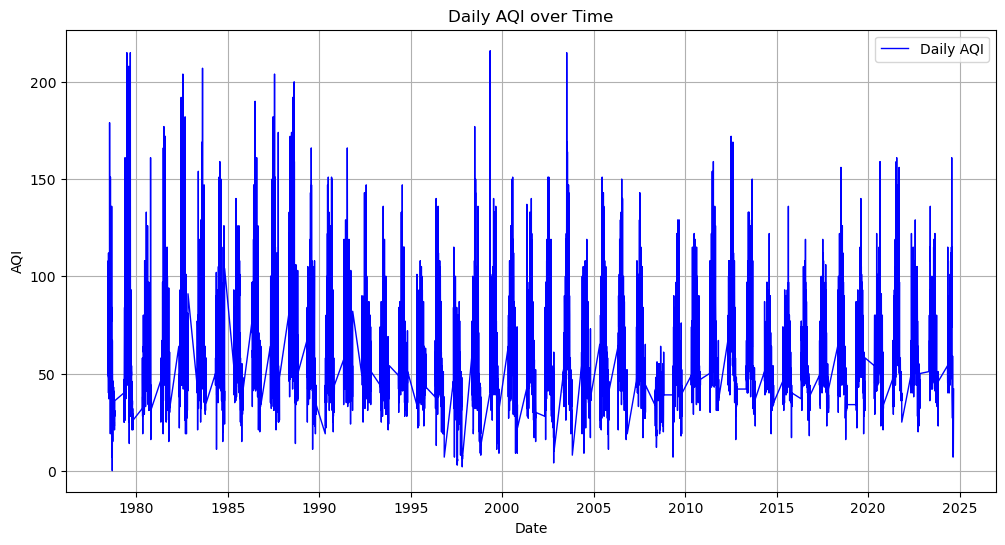

In [50]:
# Ensure 'date_local' is a datetime type
daily_aqi_results['date_local'] = pd.to_datetime(daily_aqi_results['date_local'])

# Plot AQI over time
plt.figure(figsize=(12, 6))
plt.plot(daily_aqi_results['date_local'], daily_aqi_results['aqi'], label='Daily AQI', color='b', linewidth=1)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Daily AQI over Time')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

Because I was curious, I visualized the daily data and observed distinct spikes that suggest a seasonal pattern associated with the wildfire months. This was kind of expected but it was fun to see regardless.

In [51]:
yearly_aqi_results

,year,average_aqi
0,1978,55.601504
1,1979,67.342391
2,1980,49.010929
3,1981,64.347826
4,1982,70.184783
5,1983,66.304348
6,1984,62.538043
7,1985,55.614130
8,1986,62.603261
9,1987,71.684783


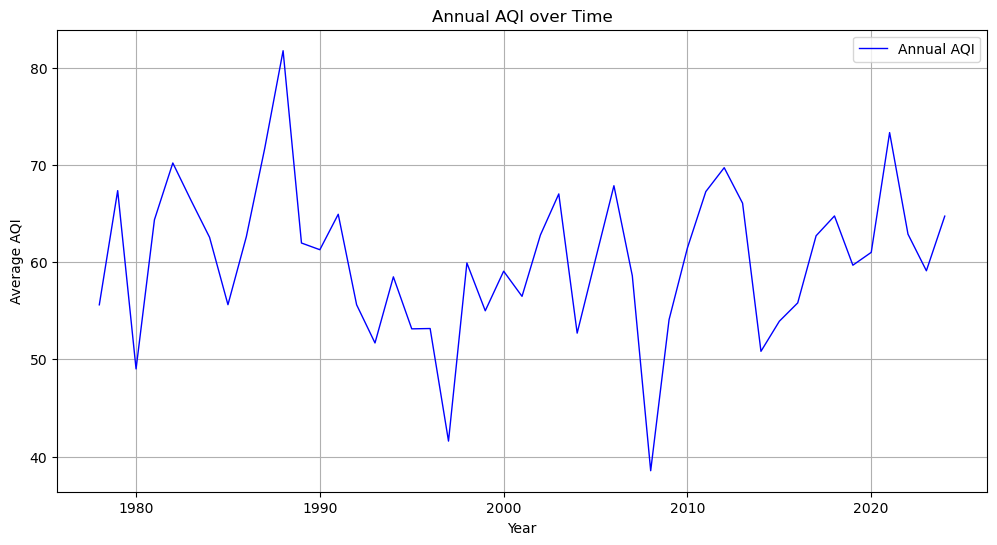

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(yearly_aqi_results['year'], yearly_aqi_results['average_aqi'], label='Annual AQI', color='b', linewidth=1)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Average AQI')
plt.title('Annual AQI over Time')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

Looks like there is no consistent trend in AQI improvement or decline, although we do see a lot of fluctuations.

In [53]:
# Save the yearly AQI data in a CSV file
yearly_aqi_results.to_csv("aqi_yearly.csv")